# 1. Setup and Get Data

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2
from matplotlib import pyplot as plt
# import numpy as np

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [4]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [5]:
!labelme

2024-05-19 12:34:07,445 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\ishan\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [9]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [10]:
images.as_numpy_iterator().next()

b'data\\images\\cdb8620f-15ab-11ef-8280-ec2e98a3d144.jpg'

In [11]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[ 97, 104,  88],
        [ 94, 101,  83],
        [ 88,  96,  72],
        ...,
        [132, 148, 137],
        [145, 159, 146],
        [149, 163, 150]],

       [[ 94, 101,  85],
        [ 95, 104,  85],
        [ 91, 101,  76],
        ...,
        [134, 148, 135],
        [143, 155, 143],
        [154, 166, 154]],

       [[ 91, 100,  83],
        [ 88, 100,  80],
        [ 85,  97,  73],
        ...,
        [151, 159, 146],
        [159, 165, 153],
        [164, 170, 158]],

       ...,

       [[ 97, 109,  87],
        [ 88, 100,  78],
        [ 83,  93,  69],
        ...,
        [167, 164, 171],
        [167, 164, 171],
        [172, 170, 175]],

       [[ 90, 102,  80],
        [ 92, 104,  82],
        [ 92, 102,  78],
        ...,
        [178, 176, 181],
        [168, 167, 172],
        [165, 165, 167]],

       [[ 91, 103,  81],
        [ 92, 104,  82],
        [ 97, 107,  83],
        ...,
        [171, 169, 174],
        [167, 167, 169],
        [165, 165, 167]]

In [14]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [15]:
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_generator.next()

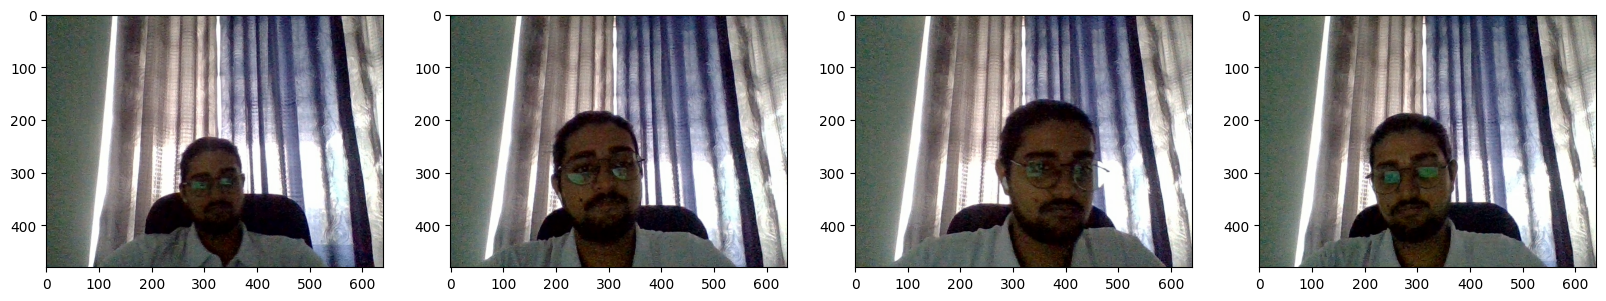

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [22]:
120*.7 # 63 to train

84.0

In [23]:
120*.15 # 14 and 13 to test and val

18.0

### 3.2 Move the Matching Labels

In [18]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [19]:
import albumentations as alb

In [20]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [21]:
img = cv2.imread(os.path.join('data','train', 'images','6b6877ce-158b-11ef-a0d1-ec2e98a3d144.jpg'))

In [22]:
with open(os.path.join('data', 'train', 'labels', '6b6877ce-158b-11ef-a0d1-ec2e98a3d144.json'), 'r') as f:
    label = json.load(f)

In [23]:
label['shapes'][0]['points']

[[201.3008130081301, 174.14634146341464],
 [358.2113821138212, 332.68292682926824]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [24]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [25]:
coords

[201.3008130081301, 174.14634146341464, 358.2113821138212, 332.68292682926824]

In [26]:
coords = list(np.divide(coords, [640,480,640,480]))

In [27]:
coords

[0.3145325203252033,
 0.36280487804878053,
 0.5597052845528456,
 0.6930894308943089]

### 4.4 Apply Augmentations and View Results

In [28]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [29]:
augmented['bboxes'][0][2:]

(0.5582475158084915, 0.6663414634146341)

In [30]:
augmented['bboxes']

[(0.2095573622402891,
  0.3140379403794039,
  0.5582475158084915,
  0.6663414634146341)]

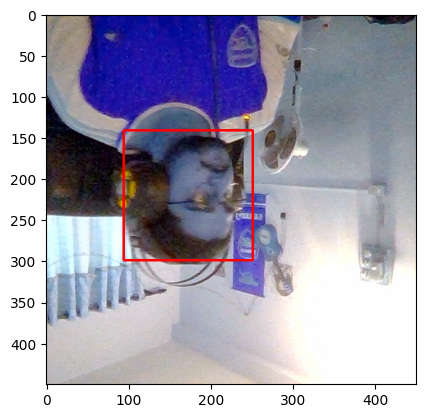

In [31]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [32]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [33]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [34]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [35]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [36]:
train_images.as_numpy_iterator().next()

array([[[0.14362745, 0.1740196 , 0.24313726],
        [0.1341299 , 0.15667892, 0.22971813],
        [0.1377451 , 0.1495098 , 0.21911764],
        ...,
        [0.6286152 , 0.7384191 , 0.8913603 ],
        [0.61378676, 0.7127451 , 0.8693015 ],
        [0.58682597, 0.6922181 , 0.8417279 ]],

       [[0.125     , 0.17058824, 0.23382352],
        [0.14154412, 0.17506127, 0.24356617],
        [0.14852941, 0.1764706 , 0.25196078],
        ...,
        [0.66133577, 0.759375  , 0.9162378 ],
        [0.62150735, 0.7186887 , 0.8759804 ],
        [0.60128677, 0.6963848 , 0.85471815]],

       [[0.14724265, 0.18578431, 0.2514706 ],
        [0.1338848 , 0.17555147, 0.2476103 ],
        [0.13431373, 0.17745098, 0.2637255 ],
        ...,
        [0.66219366, 0.76023287, 0.9170956 ],
        [0.63621324, 0.7273897 , 0.8876838 ],
        [0.6156863 , 0.71727943, 0.8625613 ]],

       ...,

       [[0.14264706, 0.14264706, 0.18480392],
        [0.1420956 , 0.13817401, 0.20091912],
        [0.14509805, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [37]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [38]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [42]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5700, 5700, 2580, 2580, 2520, 2520)

### 7.2 Create Final Datasets (Images/Labels)

In [43]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [44]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [45]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [46]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.3977 , 0.2935 , 0.58   , 0.543  ],
        [0.7363 , 0.3813 , 0.9976 , 0.734  ],
        [0.451  , 0.422  , 0.7397 , 0.7383 ],
        [0.1676 , 0.2957 , 0.4893 , 0.6426 ],
        [0.4812 , 0.3367 , 0.6924 , 0.566  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.6577 , 0.05487, 0.9883 , 0.4578 ],
        [0.1515 , 0.3936 , 0.4387 , 0.688  ]], dtype=float16))

### 7.3 View Images and Annotations

In [47]:
data_samples = train.as_numpy_iterator()

In [48]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


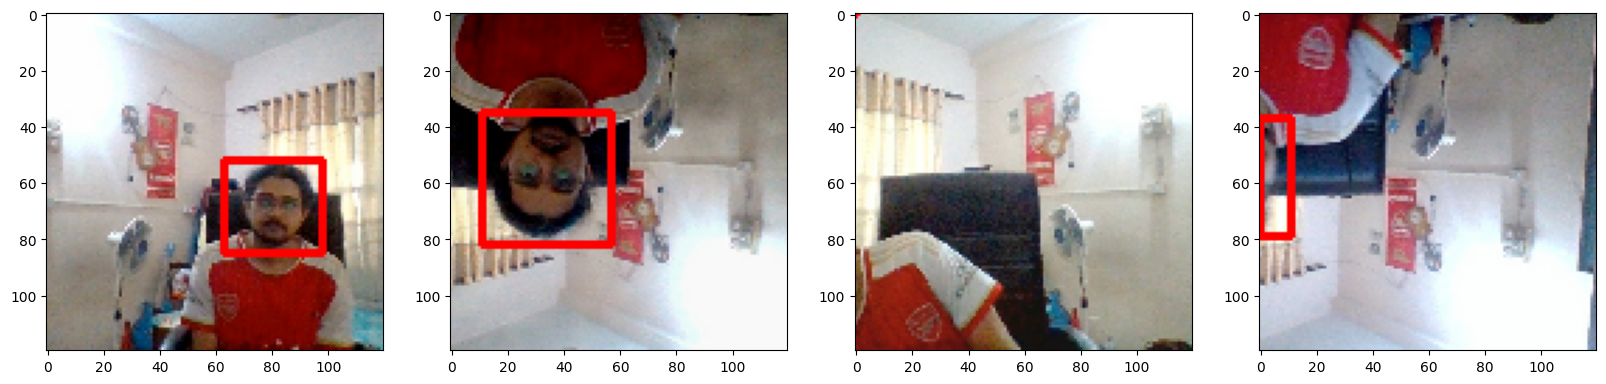

In [49]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [51]:
vgg = VGG16(include_top=False)

In [52]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [53]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [54]:
facetracker = build_model()

In [55]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [56]:
X, y = train.as_numpy_iterator().next()

In [57]:
X.shape

(8, 120, 120, 3)

In [58]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 7s 7s/step


In [59]:
classes, coords

(array([[0.29607737],
        [0.221361  ],
        [0.25897563],
        [0.27214855],
        [0.27801755],
        [0.22952585],
        [0.27350807],
        [0.3017042 ]], dtype=float32),
 array([[0.4871751 , 0.48046514, 0.31792933, 0.71787727],
        [0.51119465, 0.38422287, 0.33953056, 0.73915714],
        [0.46386147, 0.41707027, 0.28549218, 0.71115255],
        [0.47651097, 0.5048519 , 0.33646968, 0.67243904],
        [0.44249734, 0.5578409 , 0.2991968 , 0.6402637 ],
        [0.43895546, 0.4233002 , 0.3073048 , 0.75746167],
        [0.4682075 , 0.51393765, 0.3425248 , 0.69822603],
        [0.48381585, 0.5348181 , 0.32260945, 0.6507749 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [60]:
len(train)

713

In [61]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [62]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [63]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [64]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [65]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.6061728>

In [66]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0478203>

In [67]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.6061728>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [68]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [69]:
model = FaceTracker(facetracker)

In [70]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [71]:
logdir='logs'

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [73]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
713/713 [==============================] - 105s 133ms/step - total_loss: 0.4390 - class_loss: 0.1343 - regress_loss: 0.3718 - val_total_loss: 0.3426 - val_class_loss: 0.0781 - val_regress_loss: 0.3035
Epoch 2/20
713/713 [==============================] - 97s 118ms/step - total_loss: 0.0963 - class_loss: 0.0257 - regress_loss: 0.0835 - val_total_loss: 0.8041 - val_class_loss: 0.5165 - val_regress_loss: 0.5458
Epoch 3/20
713/713 [==============================] - 109s 118ms/step - total_loss: 0.0523 - class_loss: 0.0109 - regress_loss: 0.0468 - val_total_loss: 0.0767 - val_class_loss: 6.1903e-04 - val_regress_loss: 0.0764
Epoch 4/20
713/713 [==============================] - 91s 120ms/step - total_loss: 0.0409 - class_loss: 0.0102 - regress_loss: 0.0358 - val_total_loss: 0.5147 - val_class_loss: 0.0030 - val_regress_loss: 0.5132
Epoch 5/20
713/713 [==============================] - 99s 125ms/step - total_loss: 0.0320 - class_loss: 0.0078 - regress_loss: 0.0281 - val_total_loss

### 10.3 Plot Performance

In [74]:
hist.history

{'total_loss': [0.019545676186680794,
  0.010081261396408081,
  0.008531143888831139,
  0.006156740244477987,
  0.008956938982009888,
  0.0021792459301650524,
  0.0078085619024932384,
  0.0024343845434486866,
  0.01535788830369711,
  0.0011238192673772573,
  0.0014298141468316317,
  0.00153670075815171,
  0.0018109370721504092,
  0.001226586289703846,
  0.0015720175579190254,
  0.0016503744991496205,
  0.002948456211015582,
  0.0016201732214540243,
  0.000884632405359298,
  0.0010260497219860554],
 'class_loss': [0.00030666645034216344,
  8.863821858540177e-05,
  0.0013900696067139506,
  0.00182305125053972,
  0.0016908873803913593,
  0.0008261135662905872,
  0.0023120527621358633,
  3.019069481524639e-05,
  0.0006149796536192298,
  0.00031002750620245934,
  3.844511866191169e-06,
  3.1472009140998125e-05,
  2.9206357794464566e-06,
  5.381362643674947e-05,
  9.846652392297983e-05,
  4.798198460775893e-06,
  1.1920931797249068e-07,
  5.453858193504857e-06,
  0.0001332480605924502,
  6.4

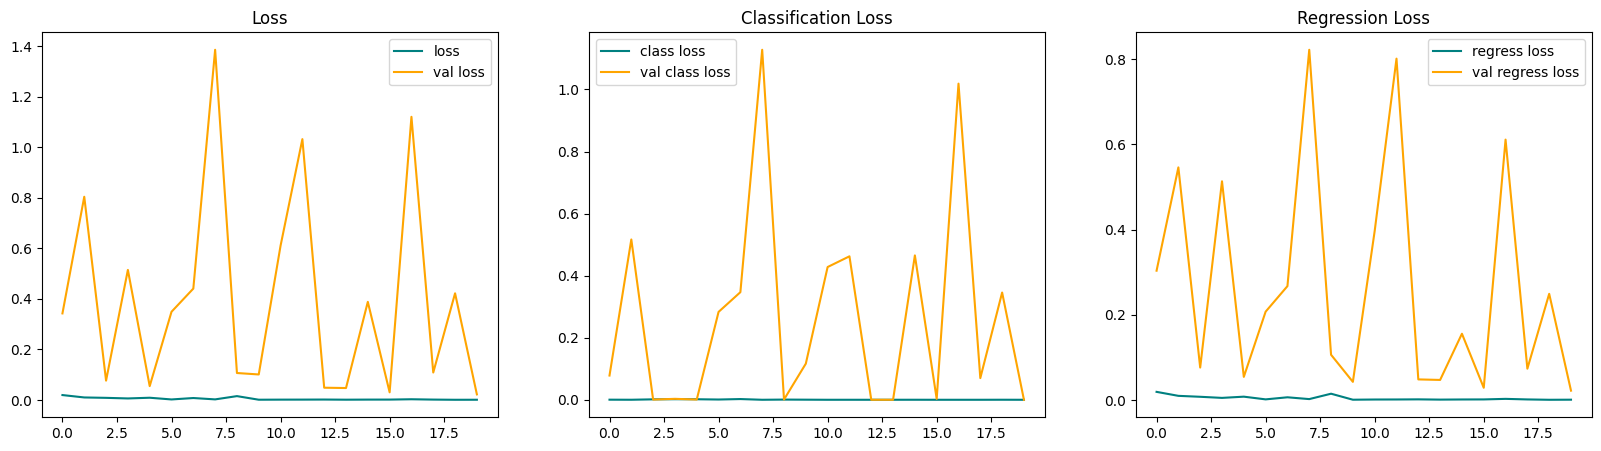

In [75]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [76]:
test_data = test.as_numpy_iterator()

In [77]:
test_sample = test_data.next()

In [78]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


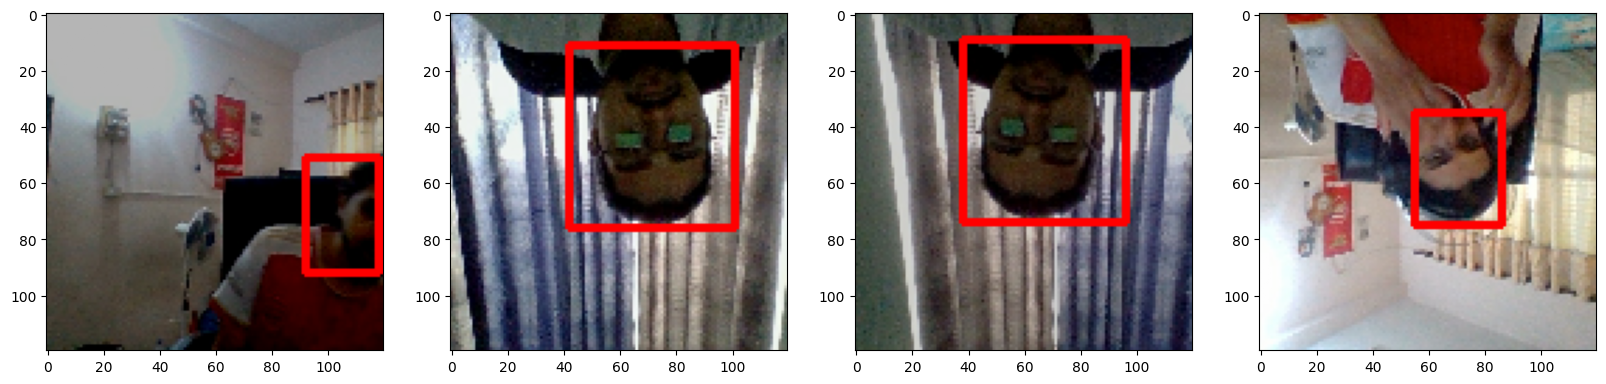

In [79]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [1]:
from tensorflow.keras.models import load_model
import cv2
import tensorflow as tf
import numpy as np

In [81]:
facetracker.save('facetracker.h5')

In [2]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [3]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 58ms/step
